In [2]:
%matplotlib inline
%config IPCompleter.greedy=True

In [3]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
# from models.schemas import Base, DublinBike
# from config import MySQL
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.externals import joblib
import lightgbm as lgb


# host = MySQL.host
# user = MySQL.username
# password = MySQL.password
# database = MySQL.database

# engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')
# Base.metadata.create_all(engine)

# session = sessionmaker()
# session.configure(bind=engine)
# s = session()

# query_bike = "SELECT *\
#          FROM dublin_bike"

# query_weather = "SELECT *\
#          FROM current_weather\
#          WHERE number = %(number)s"

# bike_df = pd.read_sql_table(table_name="dublin_bike", schema="development",  con=engine, parse_dates=['scraping_time'])
# weather_df = pd.read_sql_table(table_name="current_weather", schema="development",  con=engine, parse_dates=['scraping_time'])
# weather_df.to_pickle("./weather_df.pkl")
# bike_df.to_pickle("./bike_df.pkl")

bike_df = pd.read_pickle("./bike_df.pkl")
weather_df = pd.read_pickle("./weather_df.pkl")

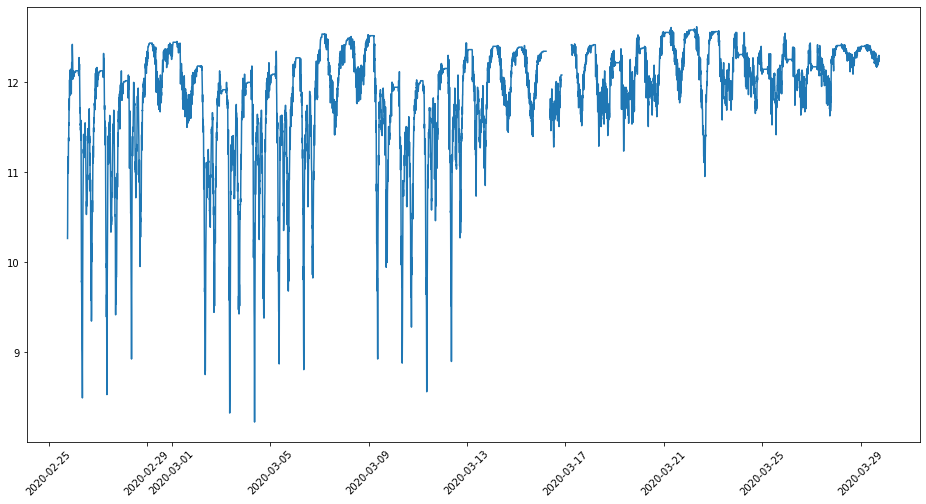

In [4]:
bike_df2 = bike_df[bike_df["number"] == 100]
bike_df2 = bike_df.resample('5Min', on='scraping_time').mean()

f, axs = plt.subplots(figsize=(16,8))
plt.plot(bike_df2['available_bike'])
plt.xticks(rotation = 45)
plt.show()

In [5]:
def labeling(df):
    df['available_bike_ratio'] = df['available_bike'] / df['bike_stand']
    df['available_bike_ratio_label'] = df['available_bike_ratio'].shift(-1308)
    df.dropna(inplace=True)
    return df

In [6]:
def labeling_eval(df):
    df['available_bike_ratio'] = df['available_bike'] / df['bike_stand']
    return df

In [7]:
def merge_df(bike_df, weather_df):
    combined_df = pd.merge(bike_df, weather_df,  how='inner',\
                           left_on=['number', 'scraping_time'],\
                           right_on = ['stationNum', 'datetime'],\
                           suffixes=('_bike','_weather'))
    return combined_df

In [8]:
def datetime_conversion(df, df_col):
    df['hour'] = df[df_col].dt.hour
    return df

In [9]:
def remove_outlier(df):    
    df = df[np.abs(df["available_bike_ratio_label"]-df["available_bike_ratio_label"].mean())<=(3*df["available_bike_ratio_label"].std())]
    return df

In [10]:
def timestamp_to_time(df, col):
    df[col] = pd.to_datetime(df[col], unit='s')
    return df

In [11]:
def time_transform(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df = df.drop([col], axis = 1)
    return df

In [12]:
def data_cleaning(df):
    pd.set_option('display.max_columns', 500)
    col_to_drop = ['address', 'site_names','bonus', 'last_update', 'datetime','icon', 'lon', 'lat', 'stationNum','available_bike_stand','description','status','sunset']
    df = df.drop(col_to_drop, axis = 1)
    df = df.drop_duplicates().reset_index()
    df = df.drop(['index'] ,axis = 1)
    df = df.drop(['scraping_time','available_bike'] ,axis = 1)

    return df

In [13]:
def data_type_conversion(df):
    categorical_col = ['code']
    df[categorical_col] = df[categorical_col].astype('category')
    df['banking'] = df['banking'].astype('int32')
    df['code'] = df['code'].astype('int32') // 100
    df['temperature'] = df['temperature'].astype('float64')
#     status_map = {'OPEN':1,'CLOSE':0}
#     df['status'] = df['status'].map(status_map)
    return df

In [14]:
def one_hot_encoding(df, col_list):
    df = pd.get_dummies(df, prefix = col_list, columns = col_list)
    return df

In [15]:
bike_df = labeling(bike_df)
combined_df = merge_df(bike_df, weather_df)
combined_df = datetime_conversion(combined_df, "scraping_time")
combined_df_no_outl = remove_outlier(combined_df)
combined_df_no_outl

,scraping_time,number,last_update,address,site_names,latitude,longitude,bike_stand,available_bike_stand,available_bike,...,icon,lon,lat,wind_spd,clouds,sunset,code,weekday,stationNum,hour
0,2020-03-24 10:52:00,2,2020-03-24 10:46:25,Blessington Street,BLESSINGTON STREET,53.3568,-6.26814,20,3,17,...,04d,-6.27,53.36,1.0,75.0,1585075524,803,2,2,10
1,2020-03-24 10:52:00,3,2020-03-24 10:50:43,Bolton Street,BOLTON STREET,53.3512,-6.26986,20,11,9,...,04d,-6.27,53.35,2.6,75.0,1585075523,803,2,3,10
2,2020-03-24 10:52:00,4,2020-03-24 10:47:27,Greek Street,GREEK STREET,53.3469,-6.27298,20,6,14,...,04d,-6.27,53.35,2.6,75.0,1585075523,803,2,4,10
3,2020-03-24 10:52:00,5,2020-03-24 10:41:25,Charlemont Street,CHARLEMONT PLACE,53.3307,-6.26018,40,18,22,...,04d,-6.26,53.33,2.6,75.0,1585075520,803,2,5,10
4,2020-03-24 10:52:00,6,2020-03-24 10:46:54,Christchurch Place,CHRISTCHURCH PLACE,53.3434,-6.27012,20,14,6,...,04d,-6.27,53.34,1.0,75.0,1585075523,803,2,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165033,2020-03-29 17:05:01,9,2020-03-29 17:00:57,Exchequer Street,EXCHEQUER STREET,53.3430,-6.26358,24,24,0,...,02d,-6.26,53.34,7.7,20.0,1585508061,801,7,9,17
165034,2020-03-29 17:05:01,10,2020-03-29 17:03:38,Dame Street,DAME STREET,53.3440,-6.26680,16,2,14,...,02d,-6.27,53.34,7.7,20.0,1585508064,801,7,10,17
165035,2020-03-29 17:05:01,11,2020-03-29 16:57:52,Earlsfort Terrace,EARLSFORT TERRACE,53.3340,-6.25837,30,20,10,...,02d,-6.26,53.33,7.7,20.0,1585508061,801,7,11,17
165036,2020-03-29 17:05:01,12,2020-03-29 16:56:39,Eccles Street,ECCLES STREET,53.3592,-6.26978,20,16,4,...,02d,-6.27,53.36,7.7,20.0,1585508065,801,7,12,17


In [16]:
print ("Shape Of The Before Ouliers: ",combined_df.shape)
print ("Shape Of The After Ouliers: ",combined_df_no_outl.shape)

Shape Of The Before Ouliers:  (165038, 28)
Shape Of The After Ouliers:  (164440, 28)


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs


[Text(0, 0.5, 'Label'), Text(0.5, 0, 'code')]

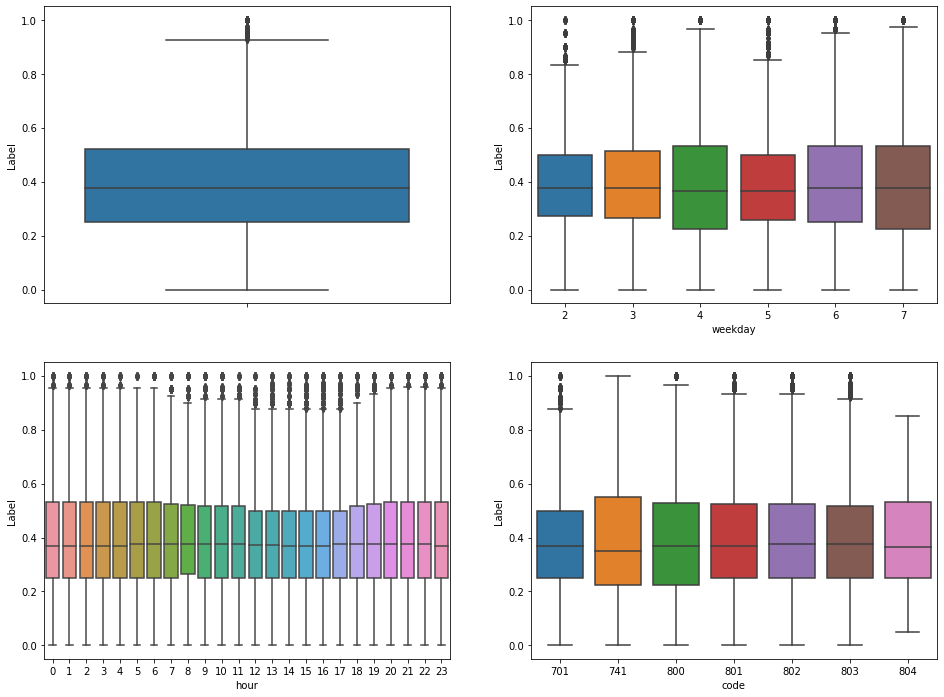

In [17]:
%time
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(16,12))
sns.boxplot(data=combined_df,y="available_bike_ratio_label",orient="v",ax=axes[0][0])
sns.boxplot(data=combined_df,y="available_bike_ratio_label",x="weekday",orient="v",ax=axes[0][1])
sns.boxplot(data=combined_df,y="available_bike_ratio_label",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=combined_df,y="available_bike_ratio_label",x="code",orient="v",ax=axes[1][1])
axes[0][0].set(ylabel='Label')
axes[0][1].set(xlabel='weekday', ylabel='Label')
axes[1][0].set(xlabel='hour', ylabel='Label')
axes[1][1].set(xlabel='code', ylabel='Label')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


[Text(0, 0.5, 'Label'), Text(0.5, 0, 'temperature')]

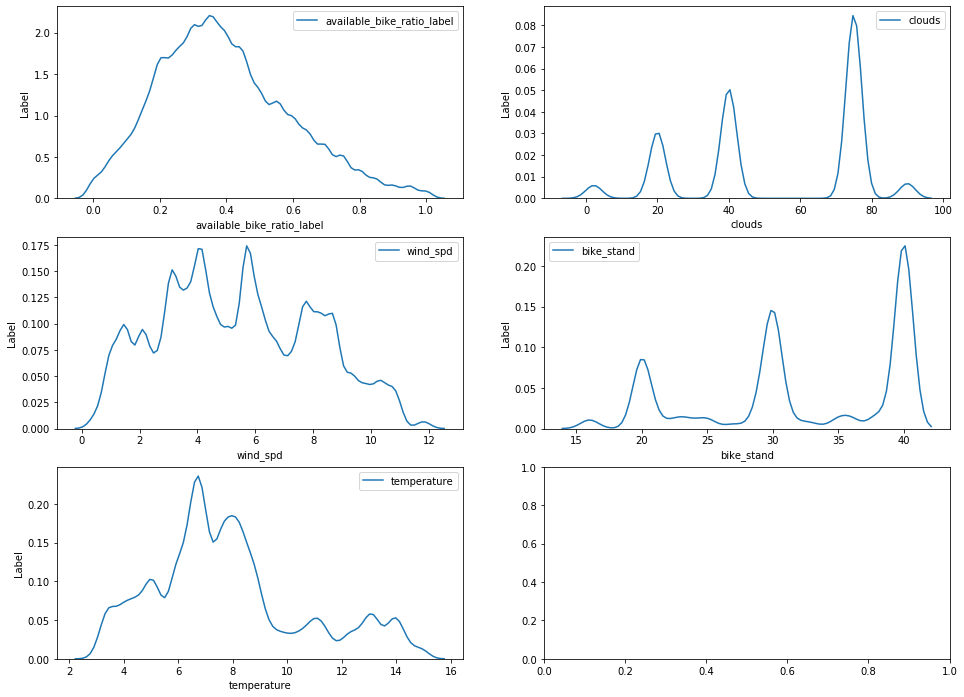

In [18]:
%time
fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(16,12))
sns.kdeplot(data=combined_df["available_bike_ratio_label"],ax=axes[0][0])
sns.kdeplot(data=combined_df["clouds"],ax=axes[0][1])
sns.kdeplot(data=combined_df["wind_spd"],ax=axes[1][0])
sns.kdeplot(data=combined_df["bike_stand"],ax=axes[1][1])
sns.kdeplot(data=combined_df["temperature"],ax=axes[2][0])

axes[0][0].set(xlabel='available_bike_ratio_label', ylabel='Label')
axes[0][1].set(xlabel='clouds', ylabel='Label')
axes[1][0].set(xlabel='wind_spd', ylabel='Label')
axes[1][1].set(xlabel='bike_stand', ylabel='Label')
axes[2][0].set(xlabel='temperature', ylabel='Label')

In [19]:
combined_df_no_outl['temperature'] = combined_df_no_outl['temperature'].astype('float64')

/Users/pie_trick/opt/anaconda3/envs/dublin-bikes/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


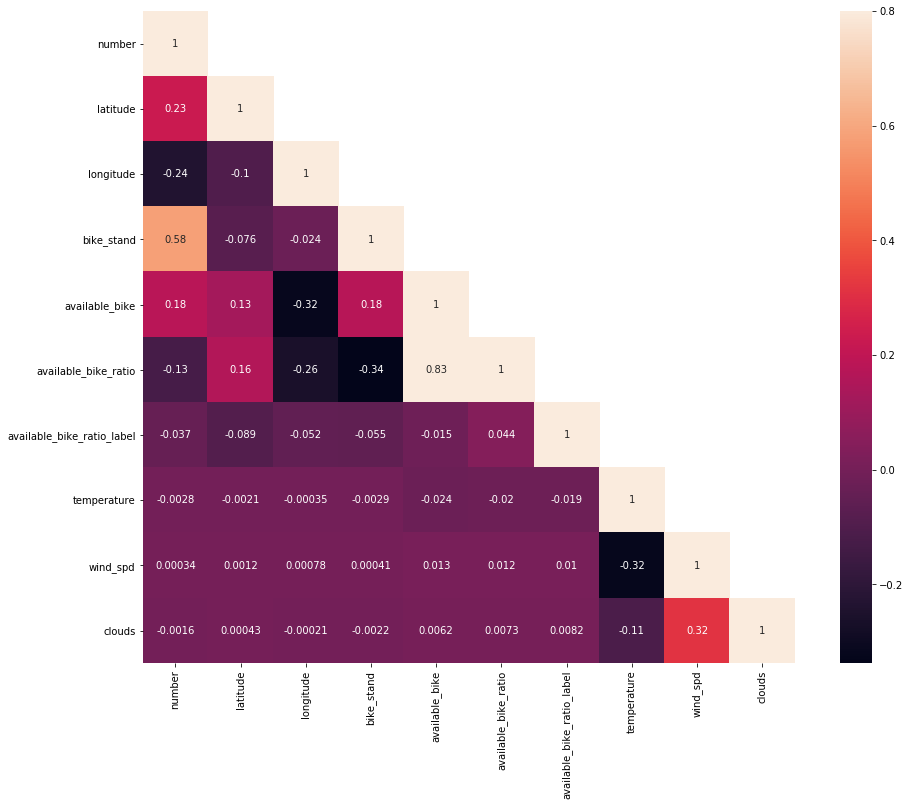

In [20]:
corrMatt = combined_df_no_outl[['number', 'latitude', 'longitude', 'bike_stand', 'available_bike', 'available_bike_ratio','available_bike_ratio_label', 'temperature', 'wind_spd', 'clouds', 'sunset', 'code']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots(figsize=(16,12))
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

CPU times: user 2.7 s, sys: 37.8 ms, total: 2.74 s
Wall time: 2.75 s


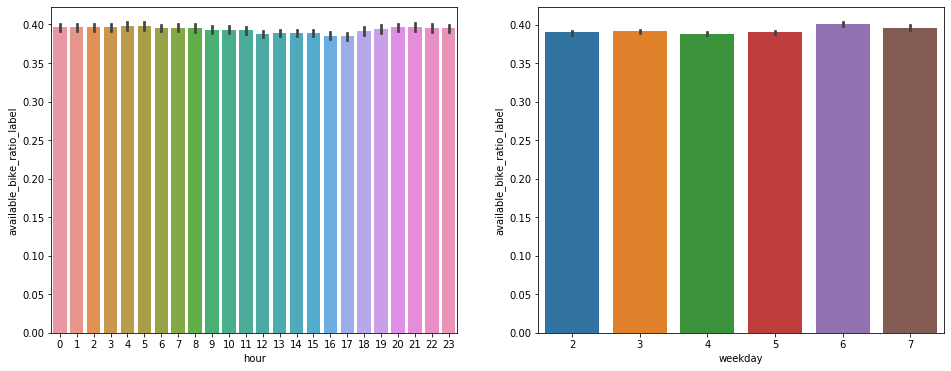

In [21]:
%%time
fig, axes = plt.subplots(ncols=2, figsize=(16,6))
sns.barplot(data = combined_df_no_outl, y = 'available_bike_ratio_label', x = 'hour', ax=axes[0])
sns.barplot(data = combined_df_no_outl, y = 'available_bike_ratio_label', x = 'weekday', ax=axes[1])

In [22]:
combined_df_no_outl = data_type_conversion(combined_df_no_outl)
combined_df_no_outl = data_cleaning(combined_df_no_outl)
combined_df_no_outl = time_transform(combined_df_no_outl, 'weekday', 7)
combined_df_no_outl = time_transform(combined_df_no_outl, 'hour', 23)

/Users/pie_trick/opt/anaconda3/envs/dublin-bikes/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/pie_trick/opt/anaconda3/envs/dublin-bikes/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/pie_trick/opt/anaconda3/envs/dublin-bikes/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set 

In [23]:
combined_df_no_outl.dtypes

number                          int64
latitude                      float64
longitude                     float64
bike_stand                      int64
banking                         int32
available_bike_ratio          float64
available_bike_ratio_label    float64
temperature                   float64
wind_spd                      float64
clouds                        float64
code                            int32
weekday_sin                   float64
weekday_cos                   float64
hour_sin                      float64
hour_cos                      float64
dtype: object

In [24]:
combined_df_no_outl.dtypes

number                          int64
latitude                      float64
longitude                     float64
bike_stand                      int64
banking                         int32
available_bike_ratio          float64
available_bike_ratio_label    float64
temperature                   float64
wind_spd                      float64
clouds                        float64
code                            int32
weekday_sin                   float64
weekday_cos                   float64
hour_sin                      float64
hour_cos                      float64
dtype: object

In [25]:
y_train = combined_df_no_outl['available_bike_ratio_label']
x_train = combined_df_no_outl.loc[:, combined_df_no_outl.columns != 'available_bike_ratio_label']

In [26]:
size = len(x_train) * 9 //10 
x_train, x_test = x_train[:size], x_train[size:]
y_train, y_test = y_train[:size], y_train[size:]
print(size)

147996


In [27]:
len(x_test.columns)

14

In [28]:
# model_param = { 'max_depth': [10, 20, 30, 40, 50],
#                  'n_estimators': [10, 30, 50, 70, 90, 110, 130],
#                 'min_samples_leaf': [1, 2, 4],
#                 'min_samples_split': [2, 5, 10]}

# #number of combinations
# n_iter = 100

# #intializing lgbm and lunching the search
# rf = RandomForestRegressor(random_state=42)
# grid_search = RandomizedSearchCV(
#     estimator=rf, 
#     param_distributions=model_param, 
#     n_iter=n_iter,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     refit=True,
#     random_state=42,
#     verbose=1,
#     n_jobs=-1)

# grid_search.fit(x_train, y_train)
# print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

# opt_parameters =  grid_search.best_params_

In [56]:
# param_grid = {
#     'max_depth': [3, 5, 7, 10,12, 15,17, 20],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1],
#     'n_estimators': [10,20,30,40, 50,60, 70,80, 90,100, 110]
# }

# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 5, n_jobs = 4, verbose = 2)

# grid_search.fit(x_train, y_train)
# print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

# opt_parameters =  grid_search.best_params_

Fitting 5 folds for each of 88 candidates, totalling 440 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   30.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 19.0min
[Parallel(n_jobs=4)]: Done 440 out of 440 | elapsed: 27.2min finished


Best score reached: 0.32161697578656334 with params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 110} 


In [92]:
opt_parameters = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 110}

In [57]:
print(opt_parameters)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 110}


In [93]:
%%time
rf_tuned = RandomForestRegressor(n_jobs= -1, **opt_parameters)
rf_tuned.fit(x_train, y_train)
scores=cross_val_score(rf_tuned, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print('{:.5f}'.format(np.mean(scores)))

-0.15777
CPU times: user 47.3 s, sys: 605 ms, total: 47.9 s
Wall time: 35.3 s


In [94]:
print(scores)

[-0.15661236 -0.16811573 -0.1677993  -0.149517   -0.14682245]


In [95]:
model_name = 'rf_model.pkl'
joblib.dump(rf_tuned, model_name, compress=3)

['rf_model.pkl']

In [96]:
%%time
model = joblib.load(model_name)
y_prediction = model.predict(x_test)
len(x_test.columns)

CPU times: user 191 ms, sys: 35.3 ms, total: 227 ms
Wall time: 231 ms


14

In [97]:
y_prediction = pd.Series(y_prediction)
y_prediction

0        0.615233
1        0.558853
2        0.606630
3        0.485117
4        0.336333
           ...   
16439    0.150852
16440    0.174581
16441    0.813641
16442    0.126954
16443    0.100006
Length: 16444, dtype: float64

In [98]:
y_test = y_test.reset_index()["available_bike_ratio_label"]
mean_squared_error(y_test, y_prediction, squared=False)

0.1391754647681995

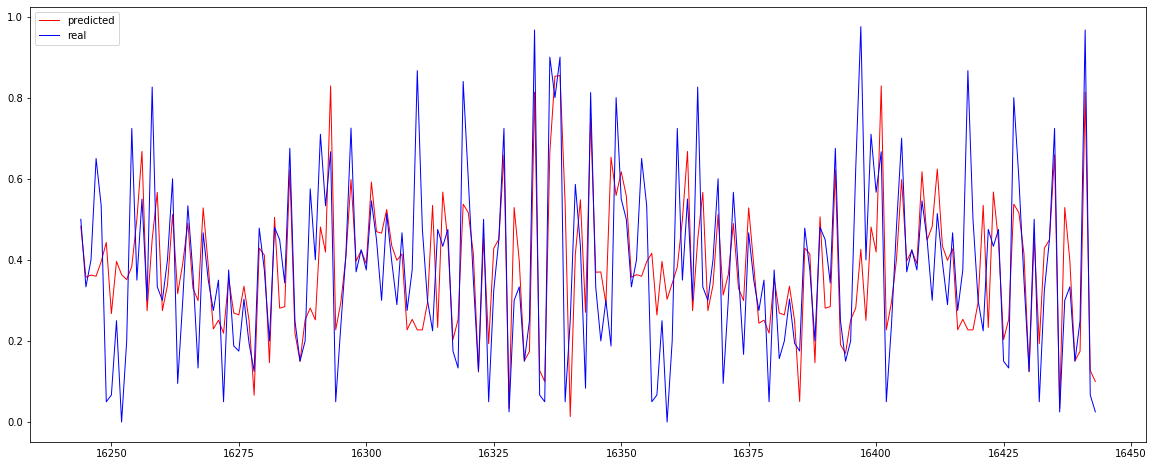

In [99]:
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(y_prediction[-200:], linewidth=1, color = 'red', label = 'predicted')
plt.plot(y_test[-200:], linewidth=1, color = 'blue', label = 'real')
plt.legend()
plt.show()

In [54]:
%%time
fit_params = {"early_stopping_rounds" : 50, 
             "eval_set" : [(x_test, y_test)],
             'eval_names': ['valid'],
             'verbose': 0}

           
param_test = {'learning_rate' : [ 0.005, 0.01, 0.02],
              'n_estimators' : [800, 900, 1000, 1100,1200],
              'num_leaves': [40, 50, 60, 70, 80, 90, 100], 
              'min_child_samples': [12, 14,15,16,18] ,
              'max_depth': [10, 20, 30, 40, 50],
              'reg_lambda': [5, 10, 15, 20],
              'min_data_in_leaf' : [5,10,15,20,25,30,35,40,45], 
              'min_gain_to_split':[0.01,0.02,0.03, 0.05, 0.08, 0.1]}

#number of combinations
n_iter = 10000


#intializing lgbm and lunching the search
lgb_reg = lgb.LGBMRegressor(boosting ='gbdt', random_state=42, silent=True, n_jobs=-1)
grid_search = RandomizedSearchCV(
    estimator=lgb_reg, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='neg_mean_squared_error',
    cv=5,
    refit=True,
    random_state=42,
    verbose=1, n_jobs=-1)

grid_search.fit(x_test, y_test, **fit_params)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters =  grid_search.best_params_

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 52.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best score reached: -0.0021603381305930944 with params: {'reg_lambda': 5, 'num_leaves': 50, 'n_estimators': 1200, 'min_gain_to_split': 0.01, 'min_data_in_leaf': 20, 'min_child_samples': 12, 'max_depth': 10, 'learning_rate': 0.02} 
CPU times: user 4min 36s, sys: 19.4 s, total: 4min 55s
Wall time: 4h 28min 42s


In [55]:
import pprint
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(opt_parameters)

{ 'learning_rate': 0.02,
  'max_depth': 10,
  'min_child_samples': 12,
  'min_data_in_leaf': 20,
  'min_gain_to_split': 0.01,
  'n_estimators': 1200,
  'num_leaves': 50,
  'reg_lambda': 5}


In [56]:
%%time
lgb_turned = lgb.LGBMRegressor(**opt_parameters)
lgb_turned.fit(x_train, y_train)
scores=cross_val_score(lgb_turned, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print('{:.5f}'.format(np.mean(scores)))

-0.15529
CPU times: user 3min 2s, sys: 3.32 s, total: 3min 6s
Wall time: 25.9 s


In [57]:
model_name = 'lgbm_model.pkl'
joblib.dump(lgb_turned, model_name)

['lgbm_model.pkl']

In [58]:
%%time
model = joblib.load(model_name)
y_prediction = model.predict(x_test)

CPU times: user 2.04 s, sys: 29.4 ms, total: 2.07 s
Wall time: 299 ms


In [59]:
y_test = y_test.reset_index()["available_bike_ratio_label"]
mean_squared_error(y_test, y_prediction, squared=False)

0.10580103906598196

In [60]:
y_prediction = pd.Series(y_prediction)
capacity = x_test['bike_stand'].reset_index().drop(['index'], axis = 1).squeeze()

In [61]:
y_prediction_inv = capacity.multiply(y_prediction)
y_test_inv = capacity.multiply(y_test)

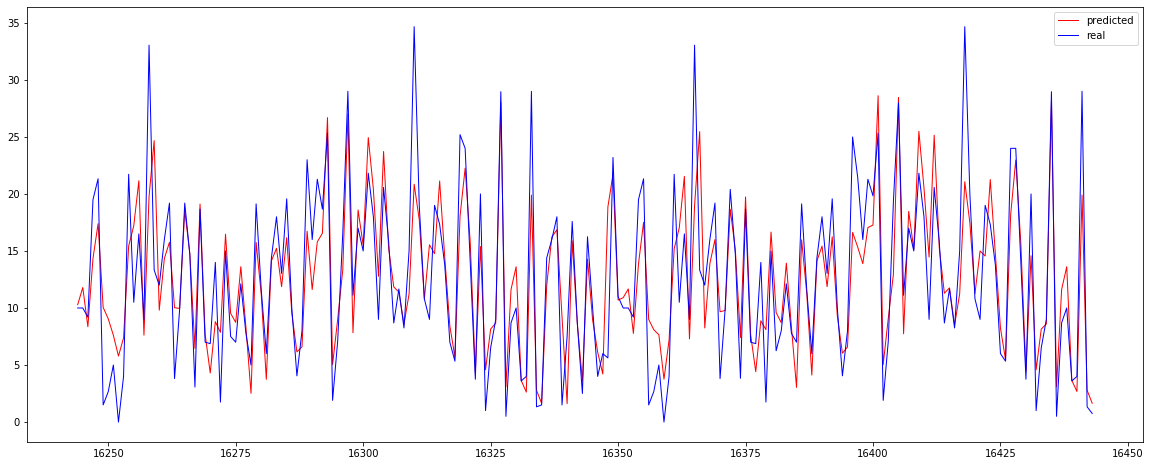

In [62]:
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(y_prediction_inv[-200:], linewidth=1, color = 'red', label = 'predicted')
plt.plot(y_test_inv[-200:], linewidth=1, color = 'blue', label = 'real')
plt.legend()
plt.show()

In [747]:
%%time
rf_sel = lgb.LGBMRegressor(**opt_parameters)
rf_sel.fit(x_train, y_train)
scores=cross_val_score(rf_sel, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print('{:.5f}'.format(np.mean(scores)))

-0.15862
CPU times: user 1min 12s, sys: 5.36 s, total: 1min 17s
Wall time: 50.6 s


In [748]:
features = pd.DataFrame()
features['feature'] = x_train.columns
features['importance'] = rf_sel.feature_importances_
features

,feature,importance
0,number,0.228973
1,latitude,0.127697
2,longitude,0.113298
3,bike_stand,0.049226
4,banking,0.010473
5,available_bike_ratio,0.116821
6,temperature,0.076236
7,wind_spd,0.049136
8,clouds,0.018661
9,code,0.006629


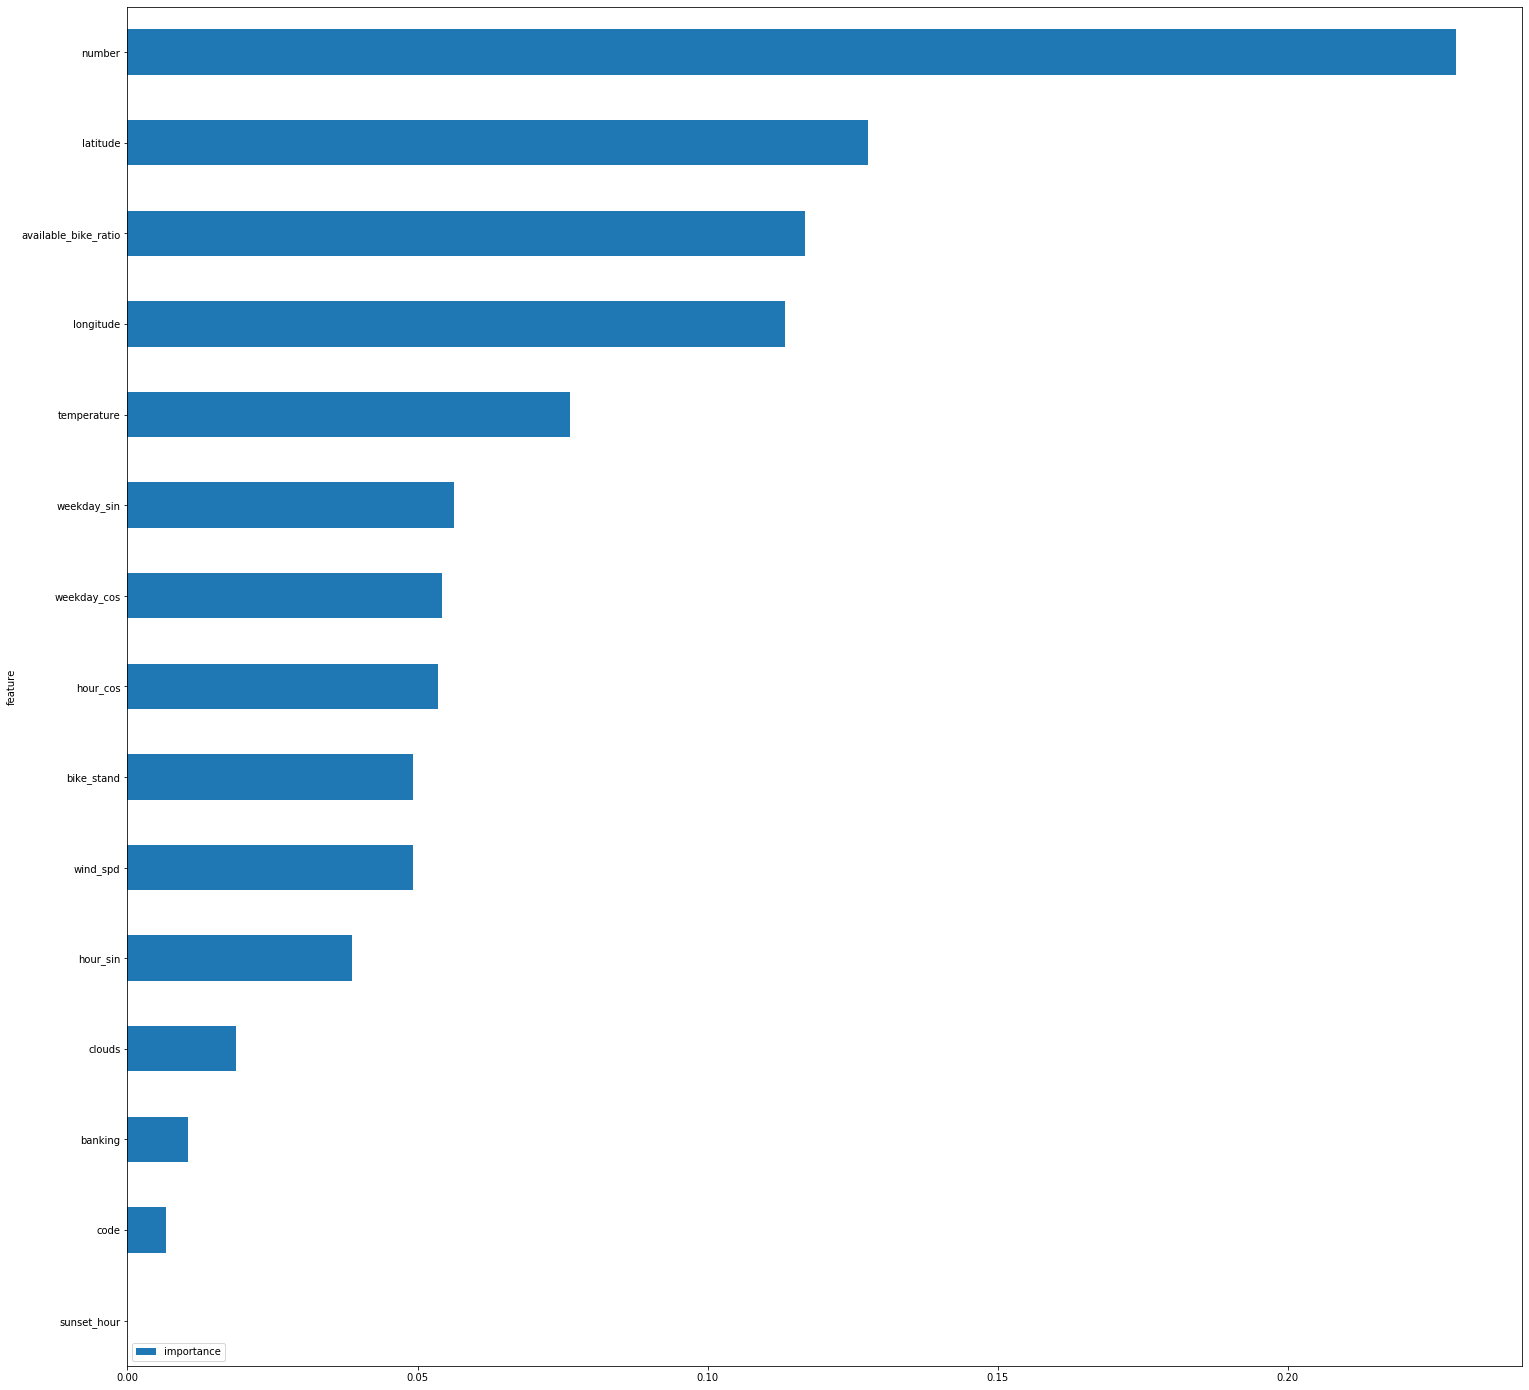

In [749]:
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(25, 25))

In [434]:
#feature selection
model = SelectFromModel(rf_sel, prefit=True)
x_train_reduced = model.transform(x_train)
print (x_train_reduced.shape)

(137771, 8)


In [435]:
x_test_reduced = model.transform(x_test)
print(x_test_reduced.shape)

(15308, 8)


In [436]:
%%time
rf_tuned = RandomForestRegressor(n_jobs= -1)
rf_tuned.fit(x_train_reduced, y_train)
scores=cross_val_score(rf_tuned, x_train_reduced, y_train, scoring='neg_root_mean_squared_error', cv=5)
print('{:.5f}'.format(np.mean(scores)))

-0.16192
CPU times: user 46.9 s, sys: 4.64 s, total: 51.5 s
Wall time: 32.2 s


In [437]:
print(scores)

[-0.16050521 -0.15847537 -0.17020765 -0.1445779  -0.17582479]


In [438]:
model_name = 'rf_model.pkl'
with open(model_name, 'wb') as handle:
    pickle.dump(rf_tuned, handle, pickle.HIGHEST_PROTOCOL)

In [439]:
%%time
with open(model_name, 'rb') as handle:     
    model = pickle.load(handle)  
y_prediction = model.predict(x_test_reduced)

CPU times: user 268 ms, sys: 255 ms, total: 523 ms
Wall time: 469 ms


In [440]:
y_prediction = pd.Series(y_prediction)
y_prediction

0        0.285714
1        0.625000
2        0.225500
3        0.075000
4        0.161964
           ...   
15303    0.295820
15304    0.694000
15305    0.369453
15306    0.347138
15307    0.133333
Length: 15308, dtype: float64

In [441]:
y_test = y_test.reset_index()["available_bike_ratio_label"]
mean_squared_error(y_test, y_prediction, squared=False)

0.12444094480046208

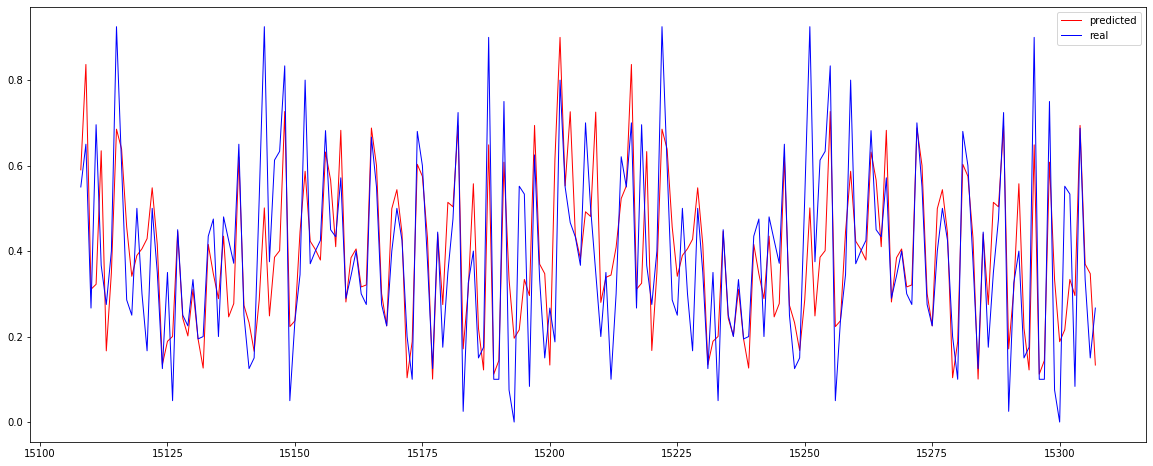

In [442]:
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(y_prediction[-200:], linewidth=1, color = 'red', label = 'predicted')
plt.plot(y_test[-200:], linewidth=1, color = 'blue', label = 'real')
plt.legend()
plt.show()